<a href="https://colab.research.google.com/github/jannisleu/iANNwTF/blob/main/HW2/Colab_homework02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], as_supervised=True)

def prepare_mnist_data(mnist):
  #flatten the images into vectors
  mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))
  #convert data from uint8 to float32
  mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
  #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
  mnist = mnist.map(lambda img, target: ((img/128.)-1., target))
  #create one-hot targets
  mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  #cache this progress in memory, as there is no need to redo it; it is deterministic after all
  mnist = mnist.cache()
  #shuffle, batch, prefetch
  mnist = mnist.shuffle(1000)
  mnist = mnist.batch(16)
  mnist = mnist.prefetch(20)
  #return preprocessed dataset
  return mnist

train_dataset = train_ds.apply(prepare_mnist_data)
test_dataset = test_ds.apply(prepare_mnist_data)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [2]:
from tensorflow.keras.layers import Dense

class MyModel(tf.keras.Model):

    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        return x


In [5]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  train_accuracy_aggregator = []
  train_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [6]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 15
learning_rate = 0.1

# Initialize the model.
model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)

    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.108


Epoch: 1 starting with accuracy 0.9581
Epoch: 2 starting with accuracy 0.9647
Epoch: 3 starting with accuracy 0.9671
Epoch: 4 starting with accuracy 0.9691
Epoch: 5 starting with accuracy 0.9679
Epoch: 6 starting with accuracy 0.9585
Epoch: 7 starting with accuracy 0.9666
Epoch: 8 starting with accuracy 0.9658
Epoch: 9 starting with accuracy 0.9614
Epoch: 10 starting with accuracy 0.9711
Epoch: 11 starting with accuracy 0.969
Epoch: 12 starting with accuracy 0.9706
Epoch: 13 starting with accuracy 0.9702
Epoch: 14 starting with accuracy 0.9681


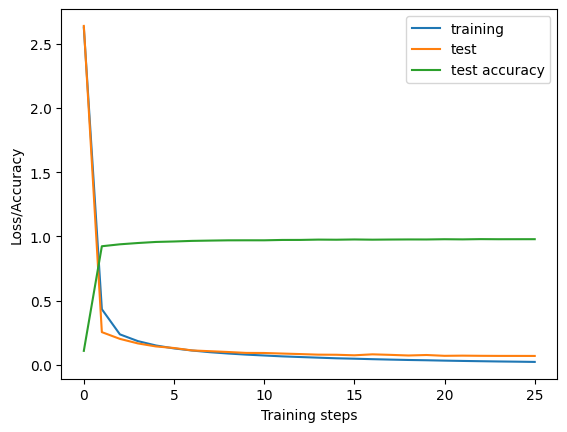

In [ ]:
import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training","test", "test accuracy"))
plt.show()

### Hyperparameter Setups ###

1. lr = 0.01, batchsize = 32, num_epochs = 10, optimizer: SDG, no momentum  
steady increase of test accuracy, 0.9710   
2. lr = 0.001, batchsize = 32, num_epochs = 20, optimizer: SDB, no momentum   
steady increase of test accuracy, 0.9428
3. lr = 0.01, batchsize = 32, num_epochs = 25, optimizer: SDB, no momentum   
accuracy is stuck at 0.97, maybe lower lr should be used after the first 10-15 epochs, final accuracy: 0.9782
4. lr = 0.1, batchsize = 16, num_epochs = 15, optimizer: SGD, no momentum   0.968, lr seems too high, fluctuation of accuracy